Import necessary Libraries

In [ ]:
#Use Javascript code to call your local webcam
from IPython.display import display, Javascript
from google.colab.output import eval_js
#Convert the image type that captured by webcam
from base64 import b64decode, b64encode

import numpy as np
from PIL import Image

import io
# OpenCV library 
import cv2 
# plot the img
from google.colab.patches import cv2_imshow

### Mount your google drive


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load cascades using v2.CascadeClassifier
faces_cascades = cv2.CascadeClassifier("/content/drive/MyDrive/Computer_Vision/haarcascade_frontalface_default.xml")



---
### The following code takes care of using your webcame, take a capture and send it to collab


In [ ]:
from google.colab.output import eval_js

def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);
      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }

    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.20);

            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)


### Define the Image Conversion function

For VideoCapture functions return images with base64 type

For cv2 need images with bytes type

In [ ]:
def b64_to_bytes(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def bytes_to_b64(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

In [ ]:
# This function scales a rotated rectangle by a factor of scale_x (width) and scale_y (height)
def scale_contour(pts, scale_x, scale_y):
    M = cv2.moments(pts)

    if M['m00'] == 0:
      return pts

    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cnt_norm = pts - [cx, cy]
    cnt_scaled = cnt_norm * np.array([scale_x, scale_y])
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)

    return cnt_scaled

# Will be needed in task 6 maybe
def crop_hand(pts, im_width, im_height):
  x_tl, y_tl = max(0, min(pts[:, 0])), max(0, min(pts[:, 1]))
  x_br, y_br = min(im_width, max(pts[:, 0])), min(im_height, max(pts[:, 1]))

  return(x_tl, y_tl),(x_br, y_br)

In [ ]:
# Detect faces using cascades
def detect_faces(img, cascades):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = cascades.detectMultiScale(gray, 1.3, 4)
  return faces

In [ ]:
# Capture a frame used for histogramm backprojection
VideoCapture()
eval_js('create()')

while True:
  response = input("Type anything when ready!:")
  byte = eval_js('capture()')
  im = b64_to_bytes(byte)
  im_copy = im.copy()
  faces = detect_faces(im, faces_cascades)

  if len(faces) == 1:
    face = faces[0]
    cv2.rectangle(im_copy,(face[0],face[1]),(face[0] + face[2], face[1] + face[3]),(0,255,0),2)
  else:
    continue

  eval_js('showimg("{}")'.format(bytes_to_b64(im_copy)))
  response = input("Use this bounding box? [y or n]:")
  if response == 'y':
    frame = im[face[1]:face[1]+face[3], face[0]:face[0]+face[2]]
    eval_js('showimg("{}")'.format(bytes_to_b64(frame)))
    tracking_window_face = face # Initial tracking window for the face
    break

In [ ]:
def show_hist(hist):
  bin_count = hist.shape[0]
  bin_w = 24
  img = np.zeros((256, bin_count*bin_w, 3), np.uint8)
  for i in range(bin_count):
      h = int(hist[i])
      cv2.rectangle(img, (i*bin_w+2, 255), ((i+1)*bin_w-2, 255-h), (int(180.0*i/bin_count), 255, 255), -1)
  img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
  cv2_imshow(img)

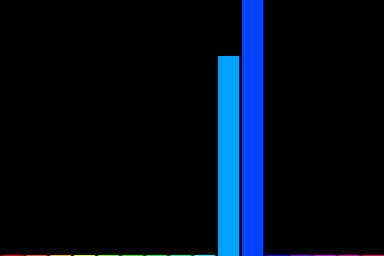

In [ ]:
# Compute the the histogram
# Transform the frame into HSV
frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# Create an inRange mask for pixels. Limit the saturation in [64., 255.] and brightness in [32., 200.]
# only contains white and black color
mask = cv2.inRange(frame_hsv, np.array((0., 64., 32.)), np.array((180., 255., 200.)))
# Compute the histogram of the frame (use only the HUE channel). See `https://bit.ly/3pdVUEd`
# Take into account only pixels which are not too bright and not too dark (use the previous mask)
# Use 16 bins and speicfy the range of the hue ([0, 180])
frame_hist = cv2.calcHist([frame_hsv], [0], mask, [16], [0,180])
# Normalize the histogram between 0 (lowest intensity) and 255 (highest intensity) (use MinMax normalization `cv.NORM_MINMAX`) using the method `https://bit.ly/3jMGhCj`
frame_hist = cv2.normalize(frame_hist, frame_hist, 0, 255, cv2.NORM_MINMAX)
# Reashape the histogram into a 1-D array (use `.reshape(-1)`)
frame_hist = frame_hist.reshape(-1)

# Show the histogram
show_hist(frame_hist)

In [ ]:
tracking_window_face

array([204, 179, 196, 196], dtype=int32)

In [ ]:
sv = tracking_window_face 

In [ ]:
PATH = '/content/drive/MyDrive/Computer_Vision/DataSet/C_32/'

In [ ]:
tracking_window_face = sv  
VideoCapture()
eval_js('create()')
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

byte = eval_js('capture()')
im = b64_to_bytes(byte)
im_width, im_height = im.shape[1],im.shape[0]
tracking_window_hand = (0,0,im_width,im_height) # Define the initial tracking window for the hand. It spans the entire caption
cpt = -1

while True:
  byte = eval_js('capture()')
  im = b64_to_bytes(byte)
  # Transform the image into HSV
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)  
  # Compute the standard not too bright not too dark mask
  mask = cv2.inRange(hsv, np.array((0., 64., 32.)), np.array((180., 200., 200.)))
  # Back project the histogramm on the hsv img
  prob = cv2.calcBackProject([hsv], [0], frame_hist, [0,180], scale=1) 
  # Apply the mask
  prob = prob & mask
 
  # First look up for the face using cam shift starting from `tracking_window_face`
  (x,y,w,h) = tracking_window_face
  bbox, tracking_window_face = cv2.CamShift(prob, tracking_window_face, term_crit)

  # Retrieve the rotated bounding rectangle
  pts = cv2.boxPoints(bbox).astype(np.int)
  # Scale the rotated bounding box 1.5x times  
  scaled_pts = scale_contour(pts, 1.5, 1.5)# Use `scale_contour`
  # Fill the rotated face bounding box with 0 in the prob map
  # Use `cv2.fillPoly`
  cv2.fillPoly(prob, [scaled_pts], 0)
  # Draw the boundix box around the face
  #cv2.polylines(prob, [pts], True, (255, 255, 255), 2)
  # Draw the scaled boundix box around the face
  cv2.polylines(im, [scaled_pts], True, (255, 0 , 0), 2)

  # Now look up for the hand using cam shift starting from `tracking_window_hand`
  bbox, tracking_window_hand = cv2.CamShift(prob, tracking_window_hand, term_crit)
  pts = cv2.boxPoints(bbox).astype(np.int)
  # Scale the contour around the hand
  pts = scale_contour(pts, 1.5, 1.5)
  
  #Detect hand
  cropped_hand_bbox = crop_hand(pts, im_width, im_height)
 
  cv2.rectangle(im, cropped_hand_bbox[0], cropped_hand_bbox[1], (0, 255, 0), 2)
  
  if cropped_hand_bbox[1][1] !=0:

    cropped_hand = cv2.cvtColor(im[cropped_hand_bbox[0][1]:cropped_hand_bbox[1][1], cropped_hand_bbox[0][0]:cropped_hand_bbox[1][0]], cv2.COLOR_BGR2GRAY)
    cropped_hand = cv2.resize(cropped_hand, (32, 32))
    cpt += 1
    #print(cpt)
    cv2.imwrite(PATH + str(cpt)+'.jpg', cropped_hand)
  
  eval_js('showimg("{}")'.format(bytes_to_b64(im)))

In [ ]:
import os

In [ ]:
os.chdir('/content/drive/MyDrive/Computer_Vision/DataSet/C_32/')

In [ ]:
print(len(os.listdir(".")))

505


In [ ]:
for count, filename in enumerate(os.listdir(".")):
  if filename[-3:] == "jpg":
    plimg = Image.open(filename)
    out = plimg.transpose(Image.FLIP_LEFT_RIGHT)
    out.save(filename[:-4] + '_flipped' + '.jpg')

In [ ]:
print(len(os.listdir(".")))

1010


In [ ]:
file ="102_flipped.jpg"

In [ ]:
file[-5:]

'd.jpg'